# Optimal Transport Samplers Tutorial

In [1]:
import math
import os
import time
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
from bionemo.moco.interpolants import EquivariantOTSampler, OTSampler

from sklearn.datasets import make_moons

# Task Setup
### Demonstrating the effectiveness of OT sampler and Kabsch-based Equivariant OT sampler

#### 1. We will start with the OT sampler. The OT sampler is an implementation of the "OT-CFM" algorithm proposed by [Tong et. al](https://arxiv.org/pdf/2307.03672). For a batch of randomly sampled noise ($\mathrm{x}_0$) and data ($\mathrm{x}_1$), the OT sampler will sample $(x_0, x_1)$ pairs based on their Euclidean distances. We will demonstrate how to use the OT sampler with a simple 2D example.

##### 1.1 Sample 100 points from a standard Gaussian distribution ($\mathrm{x}_0 \sim \pi_0$, orange colored), and another 100 points from a double moon-shape distribution ($\mathrm{x}_1 \sim \pi_1$, blue colored). The linear interpolation between pairs ($x_0^i, x_1^i$) are plotted using grey lines. 

In [2]:
def sample_moons(n, normalize = False):
    x1, _ = make_moons(n_samples=n, noise=0.08)
    x1 = torch.Tensor(x1)
    x1 =  x1 * 3 - 1
    if normalize:
        x1 = (x1 - x1.mean(0))/x1.std(0) * 2
    return x1

def sample_gaussian(n, dim = 2):
    return torch.randn(n, dim)

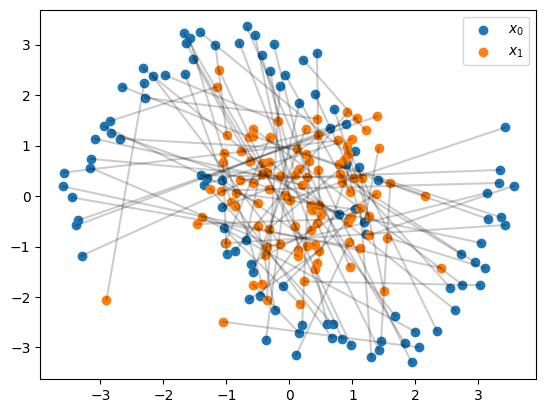

In [3]:
# Sample x0 and x1
x1 = sample_moons(100, normalize=True).numpy()
x0 = sample_gaussian(100).numpy()
# Plot data points and linear interpolation
plt.scatter(x1[:, 0], x1[:, 1], label='$x_0$')
plt.scatter(x0[:, 0], x0[:, 1], label='$x_1$')
x0 = np.asarray(x0)
x1 = np.asarray(x1)
for i in range(len(x1)):
    plt.plot([x0[i, 0], x1[i, 0]], [x0[i, 1], x1[i, 1]], color='k', alpha=0.2)
plt.legend()

##### 1.2 Initialize the OT sampler and sample new $(x_0, x_1)$ pairs to minimize the transport cost of the entire batch. The linear interpolation between new pairs ($x_0^i, x_1^i$) are plotted using grey lines. We can see that there are less crossover of interpolation trajectories and the transport cost has been reduced.

In [4]:
# Initialize the OTSampler
ot_sampler = OTSampler(method="exact", num_threads=1)
# Sample new pairs from the OTSampler, mask is not used in this example
# Replace is set to False, so no duplicates are allowed
# Sort is set to "x0", so the order of output x0 is the same as input x0
ot_sampled_x0, ot_sampled_x1, mask = ot_sampler.apply_ot(
    torch.Tensor(x0), 
    torch.Tensor(x1), 
    mask=None, replace=False, sort="x0")
# Convert the sampled tensors to numpy arrays
ot_sampled_x0 = ot_sampled_x0.numpy()
ot_sampled_x1 = ot_sampled_x1.numpy()

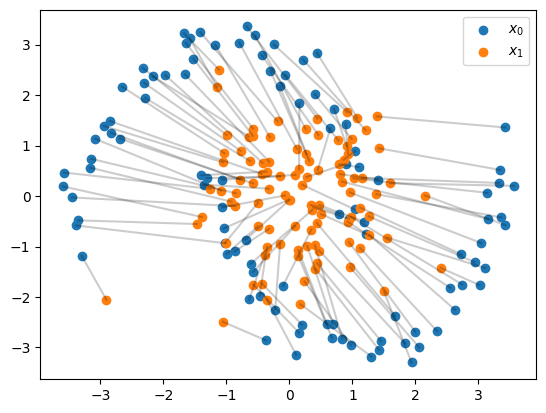

In [5]:
# Plot data points and linear interpolation
plt.scatter(ot_sampled_x1[:, 0], ot_sampled_x1[:, 1], label='$x_0$')
plt.scatter(ot_sampled_x0[:, 0], ot_sampled_x0[:, 1], label='$x_1$')
for i in range(len(x1)):
    plt.plot(
        [ot_sampled_x0[i, 0], ot_sampled_x1[i, 0]], 
        [ot_sampled_x0[i, 1], ot_sampled_x1[i, 1]], 
        color='k', alpha=0.2
    )
plt.legend()

##### 1.3 Let's see how the OT can help in conditional flow matching training. We will train two models, one with OT and the other one without, and compare the flow trajectory during sampling.

Note the ContinuousFlowMatcher object can be initialized with any batch augmentation using the 'ot_type' parameter. For clarity we pull in our previosuly initialized OT Sampler.

In [6]:
from bionemo.moco.interpolants import ContinuousFlowMatcher
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.distributions.prior import GaussianPrior

def trainCFM(use_ot=False):
    # Initialize model, optimizer, and flow matcher
    dim = 2
    hidden_size = 64
    batch_size = 256
    model = torch.nn.Sequential(
                torch.nn.Linear(dim + 1, hidden_size),
                torch.nn.SELU(),
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.SELU(),
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.SELU(),
                torch.nn.Linear(hidden_size, dim),
            )
    optimizer = torch.optim.Adam(model.parameters())

    uniform_time = UniformTimeDistribution()
    moon_prior = GaussianPrior()
    sigma = 0.1
    cfm = ContinuousFlowMatcher(time_distribution=uniform_time, 
                                prior_distribution=moon_prior, 
                                sigma=sigma, 
                                prediction_type="velocity")

    # Place both the model and the interpolant on the same device
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(DEVICE)
    cfm = cfm.to_device(DEVICE)

    for k in range(10000):
        optimizer.zero_grad()
        shape = (batch_size, dim)
        x0 = cfm.sample_prior(shape).to(DEVICE)
        x1 = sample_moons(batch_size, normalize=False).to(DEVICE)
        if use_ot:
            x0, x1, mask = ot_sampler.apply_ot(
                x0, x1, 
                mask=None, replace=False, sort="x0"
            )
        t = cfm.sample_time(batch_size)
        xt = cfm.interpolate(x1, t, x0)
        ut = cfm.calculate_target(x1, x0)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = cfm.loss(vt, ut, target_type="velocity").mean()

        loss.backward()
        optimizer.step()

        if (k + 1) % 5000 == 0:
            print(f"{k+1}: loss {loss.item():0.3f}") 
    return model, cfm

In [7]:
# Train a model with OT
ot_model, ot_cfm = trainCFM(use_ot=True)
# Train a model without OT
no_ot_model, no_ot_cfm = trainCFM(use_ot=False)

5000: loss 0.053
10000: loss 0.058
5000: loss 2.955
10000: loss 3.211


In [8]:
# Set up the sampling time schedule
from bionemo.moco.schedules.inference_time_schedules import LinearInferenceSchedule
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
inference_sched = LinearInferenceSchedule(nsteps = 100)
schedule = inference_sched.generate_schedule().to(DEVICE)
dts = inference_sched.discretize().to(DEVICE)

In [9]:
# Sampling with the two trained models
inf_size = 1024
ot_sample = ot_cfm.sample_prior((inf_size, 2)) # Start with noise
no_ot_sample = copy.deepcopy(ot_sample) # Ensure the same starting point for both models
ot_sample, no_ot_sample = ot_sample.to(DEVICE), no_ot_sample.to(DEVICE)
ot_trajectory, no_ot_trajectory = [ot_sample], [no_ot_sample]
for dt, t in zip(dts, schedule):
    full_t  = torch.full((inf_size,), t).to(DEVICE)
    ot_vt = ot_model(torch.cat([ot_sample, full_t[:, None]], dim=-1)) # calculate the vector field based on the definition of the model
    ot_sample = ot_cfm.step(ot_vt, ot_sample, dt, full_t)
    no_ot_vt = no_ot_model(torch.cat([no_ot_sample, full_t[:, None]], dim=-1)) # calculate the vector field based on the definition of the model
    no_ot_sample = no_ot_cfm.step(no_ot_vt, no_ot_sample, dt, full_t)
    ot_trajectory.append(ot_sample) # save the trajectory for plotting purposes
    no_ot_trajectory.append(no_ot_sample) # save the trajectory for plotting purposes

##### 1.4 Visualization of flow trajectories predicted by the two models. With OT (left), the flow trajectory is straighter, thus less transport cost comapred to without OT (right).

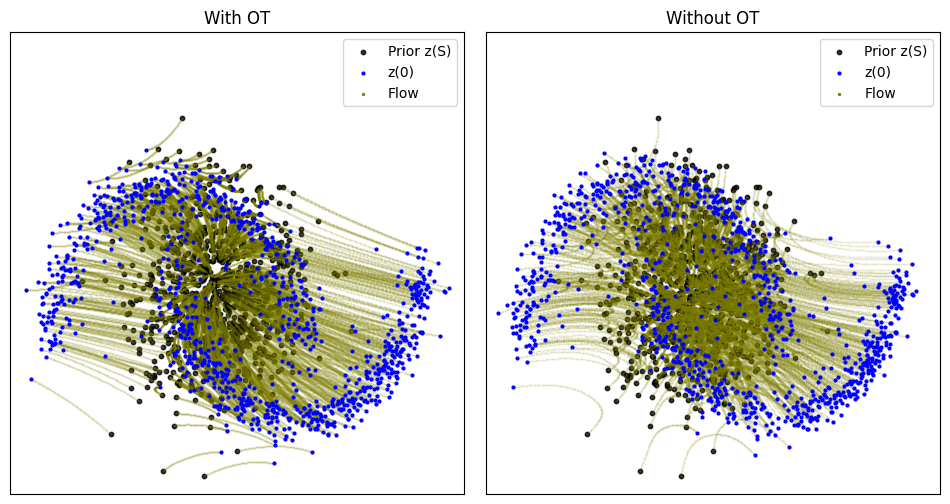

In [10]:
ot_traj = torch.stack(ot_trajectory).cpu().detach().numpy()
no_ot_traj = torch.stack(no_ot_trajectory).cpu().detach().numpy()
n = 2000

# Assuming traj is your tensor and traj.shape = (N, 2000, 2)
# where N is the number of time points, 2000 is the number of samples at each time point, and 2 is for the x and y coordinates.

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first time point in black
ax[0].scatter(ot_traj[0, :n, 0], ot_traj[0, :n, 1], s=10, alpha=0.8, c="black", label='Prior z(S)')
ax[1].scatter(no_ot_traj[0, :n, 0], no_ot_traj[0, :n, 1], s=10, alpha=0.8, c="black", label='Prior z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, ot_traj.shape[0]-1):
    ax[0].scatter(ot_traj[i, :n, 0], ot_traj[i, :n, 1], s=0.2, alpha=0.2, c="olive", zorder=1)
    ax[1].scatter(no_ot_traj[i, :n, 0], no_ot_traj[i, :n, 1], s=0.2, alpha=0.2, c="olive", zorder=1)

# Plot the last time point in blue
ax[0].scatter(ot_traj[-1, :n, 0], ot_traj[-1, :n, 1], s=4, alpha=1, c="blue", label='z(0)')
ax[1].scatter(no_ot_traj[-1, :n, 0], no_ot_traj[-1, :n, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
for i in range(2):
    ax[i].scatter([], [], s=2, alpha=1, c="olive", label='Flow')
    ax[i].legend()
    # ax[i].set_aspect('equal')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlim(-5, 6)
    ax[i].set_ylim(-4, 5)
    if i == 0:
        ax[i].set_title("With OT")
    else:
        ax[i].set_title("Without OT")
plt.subplots_adjust(wspace=0.05)
plt.show()

In [11]:

first_points = no_ot_traj[0]
last_points = no_ot_traj[-1]
distances = ((last_points - first_points)**2).sum(-1)
average_distance = np.mean(distances)

print(f"Average Distance between First and Last Points without OT: {average_distance.item()}")

first_points = ot_traj[0]
last_points = ot_traj[-1]
distances = ((last_points - first_points)**2).sum(-1)
average_distance = np.mean(distances)

print(f"Average Distance between First and Last Points with OT: {average_distance.item()}")

Average Distance between First and Last Points without OT: 4.119970321655273
Average Distance between First and Last Points with OT: 3.9200291633605957


In [12]:
def sum_of_squared_distances(trajectory):
    """
    Calculate the sum of squared distances from start to mid and mid to end of a trajectory.
    
    Parameters:
    - trajectory: A numpy array of shape (N, D) where N is the number of points 
                  in the trajectory and D is the dimensionality of the space.
                  
    Returns:
    - Sum of squared distances (start to mid + mid to end).
    """
    mid_idx = len(trajectory) // 2
    start_point = trajectory[0]
    mid_point = trajectory[mid_idx]
    end_point = trajectory[-1]
    
    start_to_mid_distance = np.linalg.norm(start_point - mid_point)
    mid_to_end_distance = np.linalg.norm(mid_point - end_point)
    
    return start_to_mid_distance**2 + mid_to_end_distance**2

# Calculate and print sum of squared distances for both trajectories
no_ot_sum_squared_distance = sum_of_squared_distances(no_ot_traj)
ot_sum_squared_distance = sum_of_squared_distances(ot_traj)

print("Sum of Squared Distances (start to mid + mid to end):")
print(f"Without OT: {no_ot_sum_squared_distance:.4f}")
print(f"With OT: {ot_sum_squared_distance:.4f}")

Sum of Squared Distances (start to mid + mid to end):
Without OT: 2667.9356
With OT: 2009.3874


#### 2. We will then introduce the Kabsch OT sampler. The Kabsch OT sampler is an implementation of the "Equivariant OT" algorithm ([Klein et al.](https://arxiv.org/abs/2306.15030)). For a batch of randomly sampled noise ($\mathrm{x}_0$) and data ($\mathrm{x}_1$), the Kabsch OT sampler will sample $(x_0, x_1)$ pairs based on the RMSD after aligning *zero-centered* $(x_0, x_1)$ using *Kabsch algorithm*. We will demonstrate how to use the Kabsch OT sampler with a simple 2D example.

In [6]:
# Define helper functions
def rotation_matrix(angle):
    theta = (angle/180.) * np.pi
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

def rotate(x, angle):
    R = rotation_matrix(angle)
    return x @ R.T

def plot_quadrilateral(x, axis, color='C0', marker='o', label=None):
    assert x.shape == (4, 2)
    axis.scatter(
        x[:, 0], x[:, 1], 
        c=color, marker=marker, linewidths=1, 
        edgecolors='k', zorder=2, label=label
    )
    for i in range(len(x)):
        if i < 3:
            axis.plot([x[i, 0], x[i+1, 0]], [x[i, 1], x[i+1, 1]], c=color, zorder=1)
        else:
            axis.plot([x[i, 0], x[0, 0]], [x[i, 1], x[0, 1]], c=color, zorder=1)
    return axis

##### 2.1 Initialize $\mathrm{k}_0$ which contains two samples. $k_0^0$ is a rhombus and $k_0^1$ is a square. Then initialize $\mathrm{k}_1$ which is rotated $\mathrm{k}_0$. Shuffle the order of $\mathrm{k}_1$ so $k_1^0$ is rotated square and $k_1^1$ is rotated rhombus. When plotting, the $k_0^0$ and $k_1^0$ are shown with circle-shaped dots while $k_0^1$ and $k_1^1$ are shown with square-shaped dots.

In [7]:
# Initialize 
k0 = np.array([
    [[-2, 0], [0, 1], [2, 0], [0, -1]], # Rhombus
    [[-1, 2], [-1, 4], [1, 4], [1, 2]], # Square
])
angles = [60, 25]

# Rotate and shuffle samples in k0 to create k1
k1 = np.array([rotate(k0[i], angles[i]) for i in [1, 0]])
markers = ['o', 's']

# Translate k0 and k1
k0 = np.array(k0)-2
k1 = np.array(k1)+2

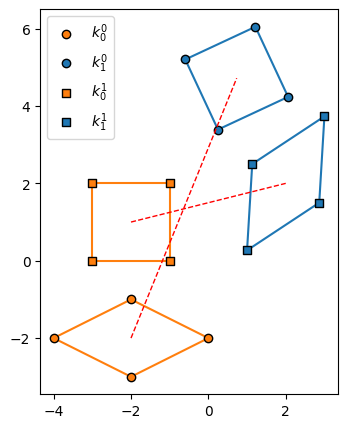

In [8]:
# Plot k0 and k1
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(len(k0)):
    plot_quadrilateral(k0[i], ax, color='C1', marker=markers[i], label='$k_0^%d$'%i)
    plot_quadrilateral(k1[i], ax, color='C0', marker=markers[i], label='$k_1^%d$'%i)
    # Calculate centroids of k0 and k1
    centroid_k0 = np.mean(k0[i], axis=0)
    centroid_k1 = np.mean(k1[i], axis=0)

    # Plot a red line connecting the centroids
    ax.plot(*zip(centroid_k0, centroid_k1), color='red', linewidth=1, linestyle='--')
ax.legend()
ax.set_aspect('equal', adjustable='box')

##### We see that we have arbitraility set up a mismatch. The orange rhombus with circle dots is tied to the blue rotated square with circle dots. We can use EquivariantOT to fix this.

##### 2.2 Initialize the Kabsch-based  Equivariant OT sampler and sample new $(k_0, k_1)$ pairs to minimize the transport cost of the entire batch after rotational alignment. We can see that the order of newly sampled $\mathrm{k}_1$ has changed to match $\mathrm{k}_0$. Note that the sampled $\mathrm{k}_1$ will be rotated but not translated.

In [9]:
# Initialize the Kabsch OT Sampler
kabsch_ot_sampler = EquivariantOTSampler(method="exact", num_threads=1)
# Sample new pairs from the EquivariantOTSampler, mask is not used in this example
# Replace is set to False, so no duplicates are allowed
# Sort is set to "x0", so the order of output x0 is the same as input x0
kabsch_k0, kabsch_k1, mask = kabsch_ot_sampler.apply_ot(
    torch.Tensor(k0), 
    torch.Tensor(k1), 
    mask=None, replace=False, sort="x0")
# Convert the sampled tensors to numpy arrays
kabsch_k0 = kabsch_k0.numpy()
kabsch_k1 = kabsch_k1.numpy()

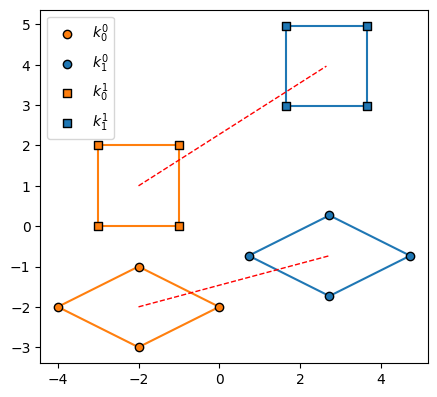

In [12]:
# Plot newly sampled k0 and k1, note that k1 is rotated to match k0
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(len(kabsch_k0)):
    plot_quadrilateral(kabsch_k0[i], ax, color='C1', marker=markers[i], label='$k_0^%d$'%i)
    plot_quadrilateral(kabsch_k1[i], ax, color='C0', marker=markers[i], label='$k_1^%d$'%i)
    # Calculate centroids of k0 and k1
    # Calculate centroids of k0 and k1
    centroid_k0 = np.mean(kabsch_k0[i], axis=0)
    centroid_k1 = np.mean(kabsch_k1[i], axis=0)

    # Plot a red line connecting the centroids
    ax.plot(*zip(centroid_k0, centroid_k1), color='red', linewidth=1, linestyle='--')
ax.legend()
ax.set_aspect('equal', adjustable='box')

#### If you wanted to align with respect to rotations and translations you could center your data or augment the EquivariantOT object